## EDS 296: Final Project

Authors: Oksana Protsukha, Leilanie Rubinstein, & Naomi Moraes

This project is assigned as the final assignment for EDS 296 - taught by Dr. Sam Stevenson. In this project we will use geospatial and temporal analysis to investigate changing environmental factors in the western region of India.

### Western Coast of India

We have decided to focus the scope of our investigation into this region - as rising heatwaves (across India) are responsible for increasing numbers of public health impacts - like heat exhaustian, sunstroke, and dehydration. Coupled with the relief/exacerbation cycles of monsoon season - we decided to look at how air surface temperature and precipitation may impact this location over time.

<p>
  <img src="images/1725154579643.jpeg" alt="Nine Agro- Climatic Zones of Maharashtra" width="40%">
  <img src="images/3496622be80cc7287.44113718.jpg" alt="Maharashtra floods 2021" width="41.3%">
</p>

<p class="attribution">
  <a href="https://www.linkedin.com/pulse/nine-agroclimatic-zones-maharashtra-significance-need-yusuf-kabir-royxf">map</a> by 
  <a href="https://in.linkedin.com/in/yusuf-kabir-937791aa">Yusuf Kabir</a> from the 
  <a href="https://www.linkedin.com/pulse/nine-agroclimatic-zones-maharashtra-significance-need-yusuf-kabir-royxf">Nine Agroclimatic zones in Maharashtra, their significance for Economic Development of Maharashtra and need for a State Climate Observatory</a> ; 
  <a href="https://media.licdn.com/dms/image/v2/D4D12AQFR7h4F6tGWzQ/article-inline_image-shrink_1000_1488/article-inline_image-shrink_1000_1488/0/1725154579643?e=2147483647&v=beta&t=7BJ80hQXwd1uXeaO3BVbCdu-wbuNAICSer2u_r6zIko">en.wikipedia.org</a>.
</p>

## Load and Query the CMIP6 AWS Catalog

In [427]:
# Import packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [428]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore(
    "https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json"
)

# Convert the catalog to a df for easier access
cat_df = catalog.df

### Data

We have chosen to use the CanESM5 and CESM2 models - due to abundance of data. As aforementioned we will be using 'tas' and 'pr'. We have also decided to use 'historical' and 'ssp245' experiment_ids, as well as 'r11i1p1f1' member_id - as these variables were found for the desired models and atmospheric variables.


## CMIP6 Data

The CMIP6 data used in this analysis is sourced from the Earth System Grid Federation (ESGF) and includes multiple climate models and scenarios. In this analysis, I used canESM5 and CESM2 models for the SSP585 scenario.

### CanESM5 model
The Canadian Earth System Model version 5 (CanESM5) is a global climate model designed to simulate past climate, forecast future changes, and support seasonal to decadal predictions. It couples atmosphere, ocean, sea ice, land surface, and carbon cycle components, with a relatively coarse resolution (500 km) that allows for large ensemble runs. 

### CESM2 model
The Community Earth System Model version 2 (CESM2) is a state-of-the-art climate model developed by the National Center for Atmospheric Research (NCAR) in the United States. It is part of the Coupled Model Intercomparison Project Phase 6 (CMIP6) and is designed to simulate the Earth's climate system, including interactions between the atmosphere, oceans, land surface, and sea ice. CESM2 is widely used for climate research and projections, providing valuable insights into future climate scenarios and their potential impacts on various regions.

### SSP245 Scenario
The Shared Socioeconomic Pathways (SSP) are a set of scenarios that describe different pathways for future socioeconomic development and their implications for greenhouse gas emissions and climate change. The SSP245 scenario represents the “Middle of the road” or moderate emissions pathway. It assumes a world with moderate economic growth, population growth, and technological development, with some level of cooperation between the states. According to [Fricko et al. (2017)](https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=about) key features of SSP245 include:
- A global final energy demand of approximately 640 EJ/year by 2050.
- Radiative forcing of 4.5 W/m² by 2100, leading to an estimated anthropogenic warming of 2.6–3.0 °C without additional mitigation.
- Limiting warming to below 2 °C would require additional mitigation efforts beyond those assumed in SSP245.



### Variables of interest
- `'tas'`: air surface temperature, which is a measure of the average temperature of the Earth's surface, including land and ocean. It is an important variable for understanding climate change and its impacts on ecosystems, weather patterns, and human health. 
- `'pr'`: precipitation, which is the amount of water that falls to the Earth's surface in the form of rain, snow, sleet, or hail. It is a crucial variable for understanding the water cycle, hydrology, and climate change impacts on water resources and ecosystems.

In [429]:
# Specify search terms to query catalog

activity_ids = ["ScenarioMIP", "CMIP"]
source_id = ["CanESM5", "CESM2"]
table_id = "Amon"
variable_id = ["tas", "pr"]
member_id = ["r11i1p1f1"]
experiment_id = ["historical", "ssp245"]

# Region of interest
lat_min, lat_max = 15.61, 22.02
lon_min, lon_max = 72.65, 80.90


In [430]:
res = catalog.search(
    activity_id=activity_ids,
    source_id=source_id,
    table_id=table_id,
    variable_id=variable_id,
    member_id=member_id,
    experiment_id=experiment_id,
)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5,historical,r11i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
1,CMIP,CCCma,CanESM5,historical,r11i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
2,ScenarioMIP,CCCma,CanESM5,ssp245,r11i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
3,ScenarioMIP,CCCma,CanESM5,ssp245,r11i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
4,CMIP,NCAR,CESM2,historical,r11i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190514
5,CMIP,NCAR,CESM2,historical,r11i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190514
6,ScenarioMIP,NCAR,CESM2,ssp245,r11i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528
7,ScenarioMIP,NCAR,CESM2,ssp245,r11i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528


In [431]:
# store historical data for CanESM5
CAN_hist_pr = xr.open_zarr(res.df["zstore"][0], storage_options={"anon": True})
CAN_hist_tas = xr.open_zarr(res.df["zstore"][1], storage_options={"anon": True})

# Store 245 scenario for CanESM5
CAN_245_pr = xr.open_zarr(res.df["zstore"][2], storage_options={"anon": True})
CAN_245_tas = xr.open_zarr(res.df["zstore"][3], storage_options={"anon": True})

# store historical data for CESM2
CESM_hist_pr = xr.open_zarr(res.df["zstore"][4], storage_options={"anon": True})
CESM_hist_tas = xr.open_zarr(res.df["zstore"][5], storage_options={"anon": True})

# Store 245 scenario for CESM2
CESM_245_pr = xr.open_zarr(res.df["zstore"][7], storage_options={"anon": True})
CESM_245_tas = xr.open_zarr(res.df["zstore"][6], storage_options={"anon": True})

In [432]:
print(CAN_hist_pr)

<xarray.Dataset> Size: 65MB
Dimensions:    (lat: 64, bnds: 2, lon: 128, time: 1980)
Coordinates:
  * lat        (lat) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
    lat_bnds   (lat, bnds) float64 1kB dask.array<chunksize=(64, 2), meta=np.ndarray>
  * lon        (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
    lon_bnds   (lon, bnds) float64 2kB dask.array<chunksize=(128, 2), meta=np.ndarray>
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 65MB dask.array<chunksize=(600, 64, 128), meta=np.ndarray>
Attributes: (12/56)
    CCCma_model_hash:            7e8e715f3f2ce47e1bab830db971c362ca329419
    CCCma_parent_runid:          rc3.1-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his11


#### Check Units

In [433]:
print(CAN_hist_pr.pr.units, CAN_hist_tas.tas.units)
print(CAN_245_pr.pr.units, CAN_245_tas.tas.units)
print(CESM_hist_pr.pr.units, CESM_hist_tas.tas.units)
print(CESM_245_pr.pr.units, CESM_245_tas.tas.units)

kg m-2 s-1 K
kg m-2 s-1 K
kg m-2 s-1 K
kg m-2 s-1 K


In [434]:
# Concatenate stored data of historical and 245 scenarios - for both models and atmospheric variables

# CanESM5
CAN_pr_data = xr.concat([CAN_hist_pr, CAN_245_pr], dim="time")
CAN_tas_data = xr.concat([CAN_hist_tas, CAN_245_tas], dim="time")


# CESM2
CESM_pr_data = xr.concat([CESM_hist_pr, CESM_245_pr], dim="time")
CESM_tas_data = xr.concat([CESM_hist_tas, CESM_245_tas], dim="time")

### Compute metrics based on extracted data

#### CanESM5 Model

In [435]:
# Compute change in precipitation and temperature over time for historical and 245 scenarios
# CanESM5
CAN_pr_time = CAN_pr_data.time.astype("datetime64[ns]")
CAN_tas_time = CAN_tas_data.time.astype("datetime64[ns]")

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
CAN_pr_lat = (CAN_pr_data.lat >= lat_min) & (CAN_pr_data.lat <= lat_max)
CAN_pr_lon = (CAN_pr_data.lon >= lon_min) & (CAN_pr_data.lon <= lon_max)

CAN_tas_lat = (CAN_tas_data.lat >= lat_min) & (CAN_tas_data.lat <= lat_max)
CAN_tas_lon = (CAN_tas_data.lon >= lon_min) & (CAN_tas_data.lon <= lon_max)

# Find points where the mask value is True, drop all other points
CAN_pr = CAN_pr_data.where(CAN_pr_lat & CAN_pr_lon, drop=True)
CAN_tas = CAN_tas_data.where(CAN_tas_lat & CAN_tas_lon, drop=True)

# Average over lat, lon dimensions to get a time series
CAN_pr = CAN_pr.mean(dim=["lat", "lon"])
CAN_tas = CAN_tas.mean(dim=["lat", "lon"])

#### CESM2 Model

In [436]:
# Compute change in precipitation and temperature over time for historical and 245 scenarios
# CESM2
CESM_pr_time = CESM_pr_data.time.astype("datetime64[ns]")
CESM_tas_time = CESM_tas_data.time.astype("datetime64[ns]")

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
CESM_pr_lat = (CESM_pr_data.lat >= lat_min) & (CESM_pr_data.lat <= lat_max)
CESM_pr_lon = (CESM_pr_data.lon >= lon_min) & (CESM_pr_data.lon <= lon_max)

CESM_tas_lat = (CESM_tas_data.lat >= lat_min) & (CESM_tas_data.lat <= lat_max)
CESM_tas_lon = (CESM_tas_data.lon >= lon_min) & (CESM_tas_data.lon <= lon_max)

# Find points where the mask value is True, drop all other points
CESM_pr = CESM_pr_data.where(CESM_pr_lat & CESM_pr_lon, drop=True)
CESM_tas = CESM_tas_data.where(CESM_tas_lat & CESM_tas_lon, drop=True)

# Average over lat, lon dimensions to get a time series
CESM_pr = CESM_pr.mean(dim=["lat", "lon"])
CESM_tas = CESM_tas.mean(dim=["lat", "lon"])

#### Convert precipitation units from  kg/m²/s to mm/day

In [437]:
# Extract NumPy arrays from xarray DataArrays and convert to mm/day
CAN_pr_np = CAN_pr.pr.values * 86400 
CESM_pr_np = CESM_pr.pr.values * 86400


#### Convert surface air temperature units from  Kelvin to Celcius

In [438]:
# Extract NumPy arrays from xarray DataArrays and convert to Celsius
CAN_tas_np = CAN_tas.tas.values - 273.15
CESM_tas_np = CESM_tas.tas.values - 273.15

# Extract NumPy arrays from xarray DataArrays for time
CAN_time_np = CAN_tas_time.values
CESM_time_np = CESM_tas_time.values

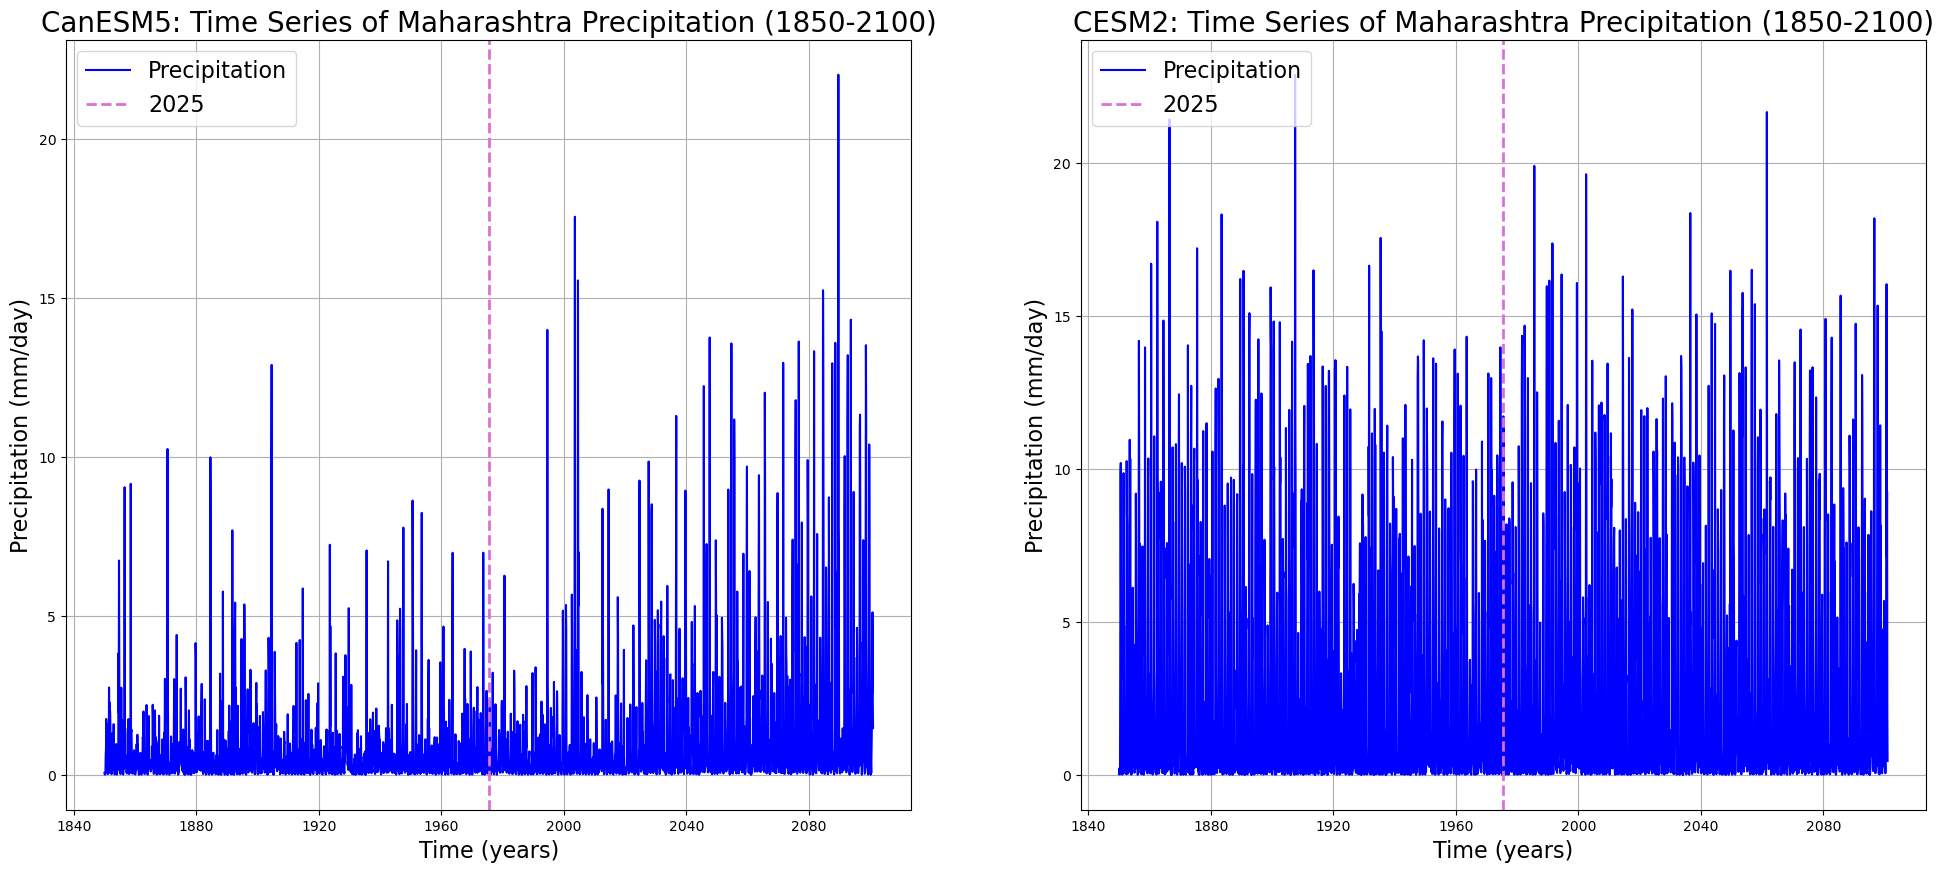

In [439]:
# Plot time series for precipitation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))

# Subplot1: CanESM5
plot1 = axes[0].plot(CAN_time_np, CAN_pr_np, label="Precipitation", color="b")
axes[0].axvline(x=2025, color="orchid", linestyle="--", linewidth=2, label="2025")
axes[0].set_title(
    "CanESM5: Time Series of Maharashtra Precipitation (1850-2100)", fontsize=20
)
axes[0].set_xlabel("Time (years)", fontsize=16)
axes[0].set_ylabel("Precipitation (mm/day)", fontsize=16)
axes[0].legend(fontsize=16)
axes[0].grid()

# Subplot2: CESM2
plot2 = axes[1].plot(CESM_time_np, CESM_pr_np, label="Precipitation", color="b")
axes[1].axvline(x=2025, color="orchid", linestyle="--", linewidth=2, label="2025")
axes[1].set_title(
    "CESM2: Time Series of Maharashtra Precipitation (1850-2100)", fontsize=20
)
axes[1].set_xlabel("Time (years)", fontsize=16)
axes[1].set_ylabel("Precipitation (mm/day)", fontsize=16)
axes[1].legend(loc="upper left", fontsize=16)
axes[1].grid()



plt.show()

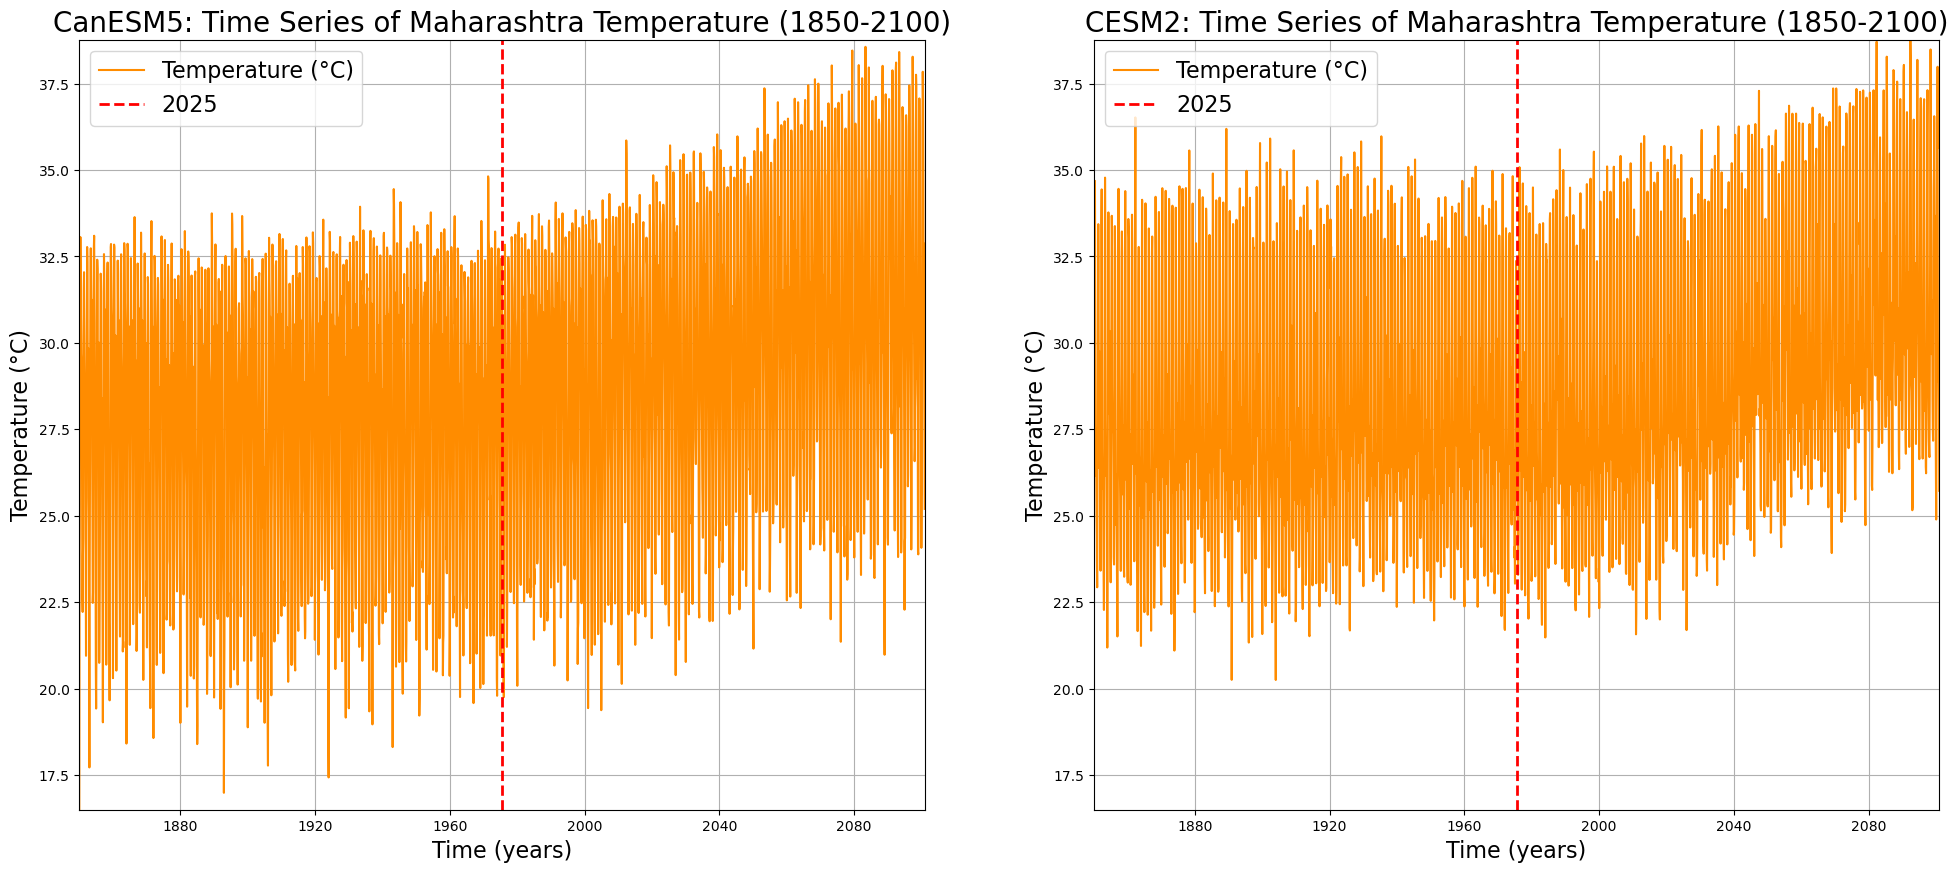

In [440]:
# Plot time series for surface air temperature 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))

# Subplot1: CanESM5
plot1 = axes[0].plot(CAN_time_np, CAN_tas_np, label="Temperature (°C)", color="darkorange")
axes[0].axvline(x=2025, color="red", linestyle="--", linewidth=2, label="2025")
axes[0].set_title(
    "CanESM5: Time Series of Maharashtra Temperature (1850-2100)", fontsize=20
)
axes[0].set_xlabel("Time (years)", fontsize=16)
axes[0].set_ylabel("Temperature (°C)", fontsize=16)
axes[0].legend(fontsize=16)
axes[0].grid()

# Subplot2: CESM2
plot2 = axes[1].plot(CESM_time_np, CESM_tas_np, label="Temperature (°C)", color="darkorange")
axes[1].axvline(x=2025, color="red", linestyle="--", linewidth=2, label="2025")
axes[1].set_title(
    "CESM2: Time Series of Maharashtra Temperature (1850-2100)", fontsize=20
)
axes[1].set_xlabel("Time (years)", fontsize=16)
axes[1].set_ylabel("Temperature (°C)", fontsize=16)
axes[1].legend(loc="upper left", fontsize=16)
axes[1].grid()

# Common x-axis and y-axis limits
x_min = min(CAN_time_np.min(), CESM_time_np.min())
x_max = max(CAN_time_np.max(), CESM_time_np.max())

y_min = min(CAN_tas_np.min(), CESM_tas_np.min())
y_max = max(CAN_tas_np.max(), CESM_tas_np.max())

# Apply limits to both axes
for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)


plt.show()

### Overlaying CanESM5 and CESM2 Temperature in Celcius Trends on One Chart

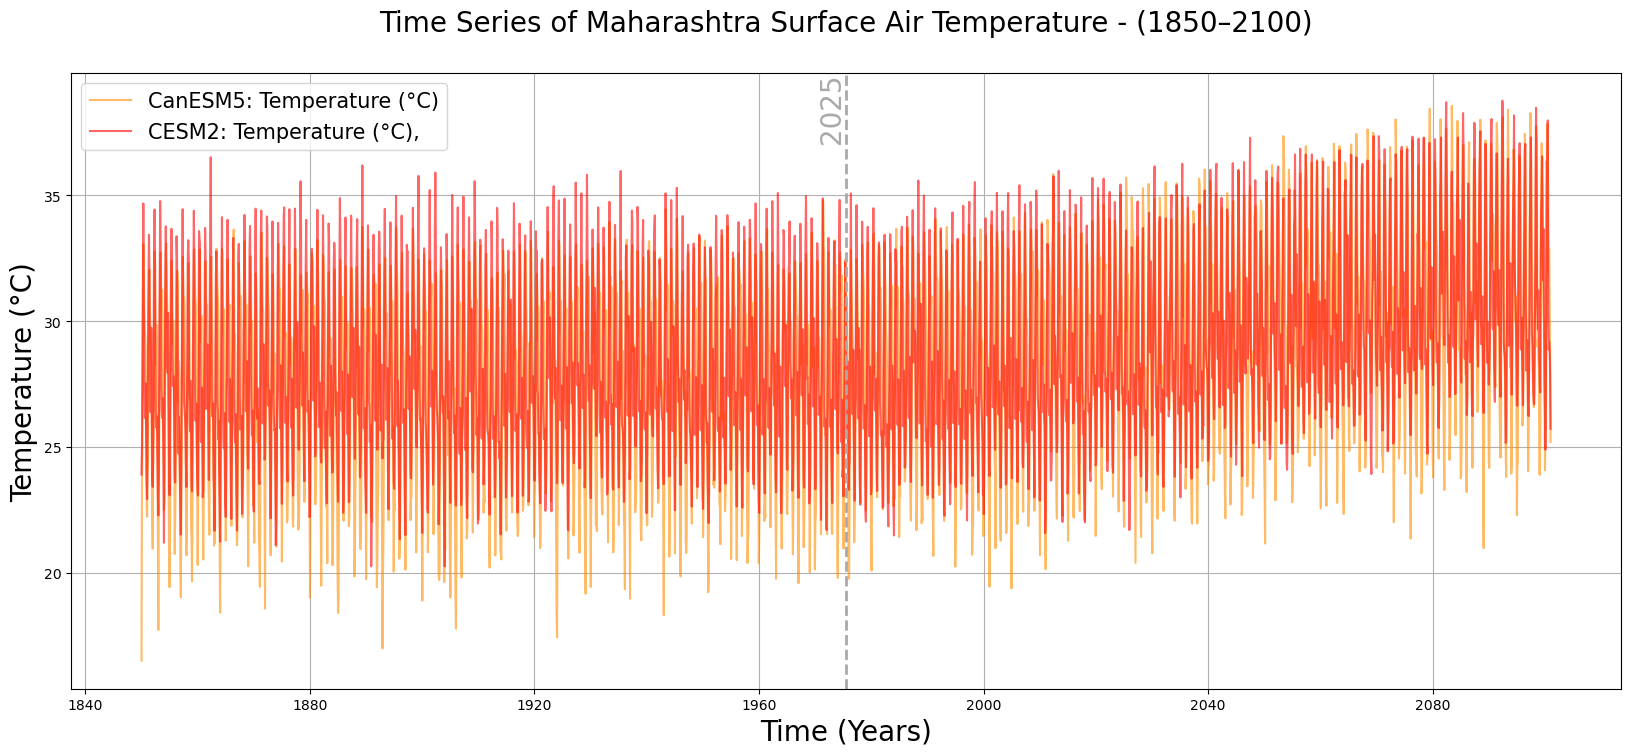

In [441]:
fig, ax = plt.subplots(figsize=(20, 8))
# Plot surface air temperature for CanESM5 model
ax.plot(CAN_time_np, CAN_tas_np, label="CanESM5: Temperature (°C)", color="darkorange", alpha=0.6)
# Plot surface air temperature for CESM2 model
ax.plot(CESM_time_np, CESM_tas_np, label="CESM2: Temperature (°C), ", color="red", alpha=0.6)

ax.axvline(x=2025, color="darkgrey", linestyle="--", linewidth=2)
ax.set_title(
    "Time Series of Maharashtra Surface Air Temperature - (1850–2100)",
    fontsize=20,
    pad=30  # Increase to add more space
)

ax.set_xlabel("Time (Years)", fontsize=20)
ax.set_ylabel("Temperature (°C)", fontsize=20)
ax.legend(fontsize=15)

# Add a vertical label for the line
ax.text(
    2025,                # x position (same as line)
    ax.get_ylim()[1],    # y position (top of y-axis)
    "2025",              # text
    rotation=90,         # vertical text
    verticalalignment='top',
    horizontalalignment='right',
    color="darkgrey",
    fontsize=20
)

ax.grid()
plt.show()

#### Alternate Method to generate time-series plots using function

In [442]:
# Create a function to plot time series
def plot_climate_time_series(
    data, time_data, variable_name, model_name, lat_bounds, lon_bounds, scenario="245"
):
    """
    Plot time series for climate data

    Parameters:
    - data: xarray dataset
    - time_data: time dimension data
    - variable_name: 'pr' or 'tas'
    - model_name: model identifier (e.g., 'CanESM5', 'CESM2')
    - lat_bounds: (lat_min, lat_max)
    - lon_bounds: (lon_min, lon_max)
    - scenario: scenario identifier for title
    """
    lat_min, lat_max = lat_bounds
    lon_min, lon_max = lon_bounds

    # Apply spatial mask
    lat_mask = (data.lat >= lat_min) & (data.lat <= lat_max)
    lon_mask = (data.lon >= lon_min) & (data.lon <= lon_max)
    data_masked = data.where(lat_mask & lon_mask, drop=True)

    # Average over spatial dimensions
    data_avg = data_masked.mean(dim=["lat", "lon"])

    # Plot
    fig, ax = plt.subplots(figsize=(20, 8))

    if variable_name == "pr":
        ax.plot(time_data, data_avg.pr, label="Precipitation", color="blue")
        ylabel = "Precipitation (kg/m²/s)"
        title = f"Time Series of Maharashtra Precipitation - {model_name} ({scenario})"
    else:
        ax.plot(time_data, data_avg.tas, label="Temperature", color="red")
        ylabel = "Temperature (K)"
        title = f"Time Series of Maharashtra Surface Air Temperature - {model_name} ({scenario})"

    ax.axvline(x=2025, color="orchid", linestyle="--", linewidth=2, label="2025")
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Time", fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.legend(fontsize=20)
    ax.grid()
    plt.show()

    return data_avg


# # Define bounds for Maharashtra
# lat_bounds = (15.61, 22.02)
# lon_bounds = (72.65, 80.90)

# # Plot all scenarios
# models = {
#     "CESM2": {
#         "pr": CESM_pr_data,
#         "tas": CESM_tas_data,
#         "time": CESM_tas.time.astype("datetime64[ns]"),
#     },
# }

# # Generate all plots
# for model_name, model_data in models.items():
#     for var in ["pr", "tas"]:
#         plot_climate_time_series(
#             data=model_data[var],
#             time_data=model_data["time"],
#             variable_name=var,
#             model_name=model_name,
#             lat_bounds=lat_bounds,
#             lon_bounds=lon_bounds,
#             scenario="Historical + SSP2-4.5",
#         )

## Visualize Changes in Air Surface Temperature and Precipitation using Maps

To visualize changes in surface air temperature and precipitation, we examine the average annual values of both variables during the monsoon season (June to September) for the historical period (1850–2024) and the SSP245 scenario (2025–2100).

#### Subset Data for Monsoon Season in Western India for Historical and SSP245 Scenario

In [443]:
# Concatenate stored data of historical and 245 scenarios - for both models and atmospheric variables

# CanESM5
CAN_map_pr = xr.concat([CAN_hist_pr, CAN_245_pr], dim="time")
CAN_map_pr['pr'] = CAN_map_pr['pr'] * 86400 # Convert kg/m²/s to mm/day
CAN_map_tas = xr.concat([CAN_hist_tas, CAN_245_tas], dim="time")
CAN_map_tas['tas'] = CAN_map_tas['tas'] - 273.15 # Convert Kelvin to Celsius



# CESM2
CESM_map_pr = xr.concat([CESM_hist_pr, CESM_245_pr], dim="time")
CESM_map_pr['pr'] = CESM_map_pr['pr'] * 86400
CESM_map_tas = xr.concat([CESM_hist_tas, CESM_245_tas], dim="time")
CESM_map_tas['tas'] = CESM_map_tas['tas'] - 273.15


### Subset Data for Monsoon Season in Western India for Historical and SSP245 Scenario

In [444]:
def subset_by_time_and_region(data, start_date, end_date, lat_min, lat_max, lon_min, lon_max, season):
    """
    Subset the data to the the period and region of interest
    """
    # subset by time
    subset_data = data.sel(time=slice(start_date, end_date))

    # subset by region
    subset_data = subset_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

    # subset by season
    subset_data = subset_data.sel(time=subset_data.time.dt.month.isin(season))  

    return subset_data

# select the data for the given time period for model1
CAN_hist_data_pr = subset_by_time_and_region(CAN_map_pr, None, '2024-12-31', lat_min, lat_max, lon_min, lon_max, [6, 7, 8, 9])
CAN_ssp_data_pr = subset_by_time_and_region(CAN_map_pr, '2025-01-01', None, lat_min, lat_max, lon_min, lon_max, [6, 7, 8, 9])

CAN_hist_data_tas = subset_by_time_and_region(CAN_map_tas, None, '2024-12-31', lat_min, lat_max, lon_min, lon_max, [6, 7, 8, 9])
CAN_ssp_data_tas = subset_by_time_and_region(CAN_map_tas, '2025-01-01', None, lat_min, lat_max, lon_min, lon_max, [6, 7, 8, 9])
# display(CAN_hist_data_pr, CAN_ssp_data_pr, CAN_hist_data_tas, CAN_ssp_data_tas)

# select the data for the given time period for cesm2
CESM_hist_data_pr = subset_by_time_and_region(CESM_map_pr, None, '2024-12-31', lat_min, lat_max, lon_min, lon_max, [6, 7, 8, 9])
CESM_ssp_data_pr = subset_by_time_and_region(CESM_map_pr, '2025-01-01', None, lat_min, lat_max, lon_min, lon_max, [6, 7, 8, 9])

CESM_hist_data_tas = subset_by_time_and_region(CESM_map_tas, None, '2024-12-31', lat_min, lat_max, lon_min, lon_max, [6, 7, 8, 9])
CESM_ssp_data_tas = subset_by_time_and_region(CESM_map_tas, '2025-01-01', None, lat_min, lat_max, lon_min, lon_max, [6, 7, 8, 9])
# display(CESM_hist_data_pr, CESM_ssp_data_pr, CESM_hist_data_tas, CESM_ssp_data_tas)

### Calculate the Difference in Precipitation And Temperature Between the Two Periods

In [445]:
# CanESM5 Model
# Difference in precipitation
CAN_hist_mn_pr = CAN_hist_data_pr['pr'].mean(dim="time") # Historical mean (1850–2024)
CAN_ssp_mn_pr = CAN_ssp_data_pr['pr'].mean(dim="time") # Future mean (2025–2100)
CAN_JJAS_diff_pr = CAN_ssp_mn_pr - CAN_hist_mn_pr
# Difference in temperature
CAN_hist_mn_tas = CAN_hist_data_tas['tas'].mean(dim="time") # Historical mean (1850–2024)
CAN_ssp_mn_tas = CAN_ssp_data_tas['tas'].mean(dim="time") # Future mean (2025–2100)
CAN_JJAS_diff_tas = CAN_ssp_mn_tas - CAN_hist_mn_tas

# CESM2 Model
# Difference in precipitation
CESM_hist_mn_pr = CESM_hist_data_pr['pr'].mean(dim="time") # Historical mean (1850–2024)
CESM_ssp_mn_pr = CESM_ssp_data_pr['pr'].mean(dim="time") # Future mean (2025–2100)
CESM_JJAS_diff_pr = CESM_ssp_mn_pr - CESM_hist_mn_pr
# Difference in temperature
CESM_hist_mn_tas = CESM_hist_data_tas['tas'].mean(dim="time") # Historical mean (1850–2024)
CESM_ssp_mn_tas = CESM_ssp_data_tas['tas'].mean(dim="time") # Future mean (2025–2100)
CESM_JJAS_diff_tas = CESM_ssp_mn_tas - CESM_hist_mn_tas

In [446]:
# Extract values from xarray DataArrays for plotting
# canESM5
CAN_hist_mn_val_pr = CAN_hist_mn_pr.values
CAN_ssp_mn_val_pr = CAN_ssp_mn_pr.values
CAN_JJAS_diff_val_pr = CAN_JJAS_diff_pr.values

CAN_hist_mn_val_tas = CAN_hist_mn_tas.values
CAN_ssp_mn_val_tas = CAN_ssp_mn_tas.values
CAN_JJAS_diff_val_tas = CAN_JJAS_diff_tas.values

# CESM2
CESM_hist_mn_val_pr = CESM_hist_mn_pr.values
CESM_ssp_mn_val_pr = CESM_ssp_mn_pr.values
CESM_JJAS_diff_val_pr = CESM_JJAS_diff_pr.values

CESM_hist_mn_val_tas = CESM_hist_mn_tas.values
CESM_ssp_mn_val_tas = CESM_ssp_mn_tas.values
CESM_JJAS_diff_val_tas = CESM_JJAS_diff_tas.values

### Create Maps to Visualize Changes in Precipitation and Temperature

In [447]:
# convert to numpy arrays and handle NaN values
CAN_hist_mn_pr_np = np.nan_to_num(CAN_hist_mn_pr, nan=0.0)
CAN_ssp_mn_pr_np = np.nan_to_num(CAN_ssp_mn_pr, nan=0.0)

CESM_hist_mn_pr_np = np.nan_to_num(CESM_hist_mn_pr, nan=0.0)
CESM_ssp_mn_pr_np = np.nan_to_num(CESM_ssp_mn_pr, nan=0.0)

print(CAN_hist_mn_pr_np.min(), CAN_hist_mn_pr_np.max(), CAN_ssp_mn_pr_np.min(), CAN_ssp_mn_pr_np.max())
print(CESM_hist_mn_pr_np.min(), CESM_hist_mn_pr_np.max(), CESM_ssp_mn_pr_np.min(), CESM_ssp_mn_pr_np.max())

0.4013285301863497 1.9196805477989594 1.3624610759091196 4.149656395316314
4.140668504578961 13.671838237579712 4.384806580679579 13.306030296965481


### Create maps to compare mean precipiation across the two models and periods

Text(0.5, 1.0, 'CESM2: JJAS Mean Precip (SSP245)')

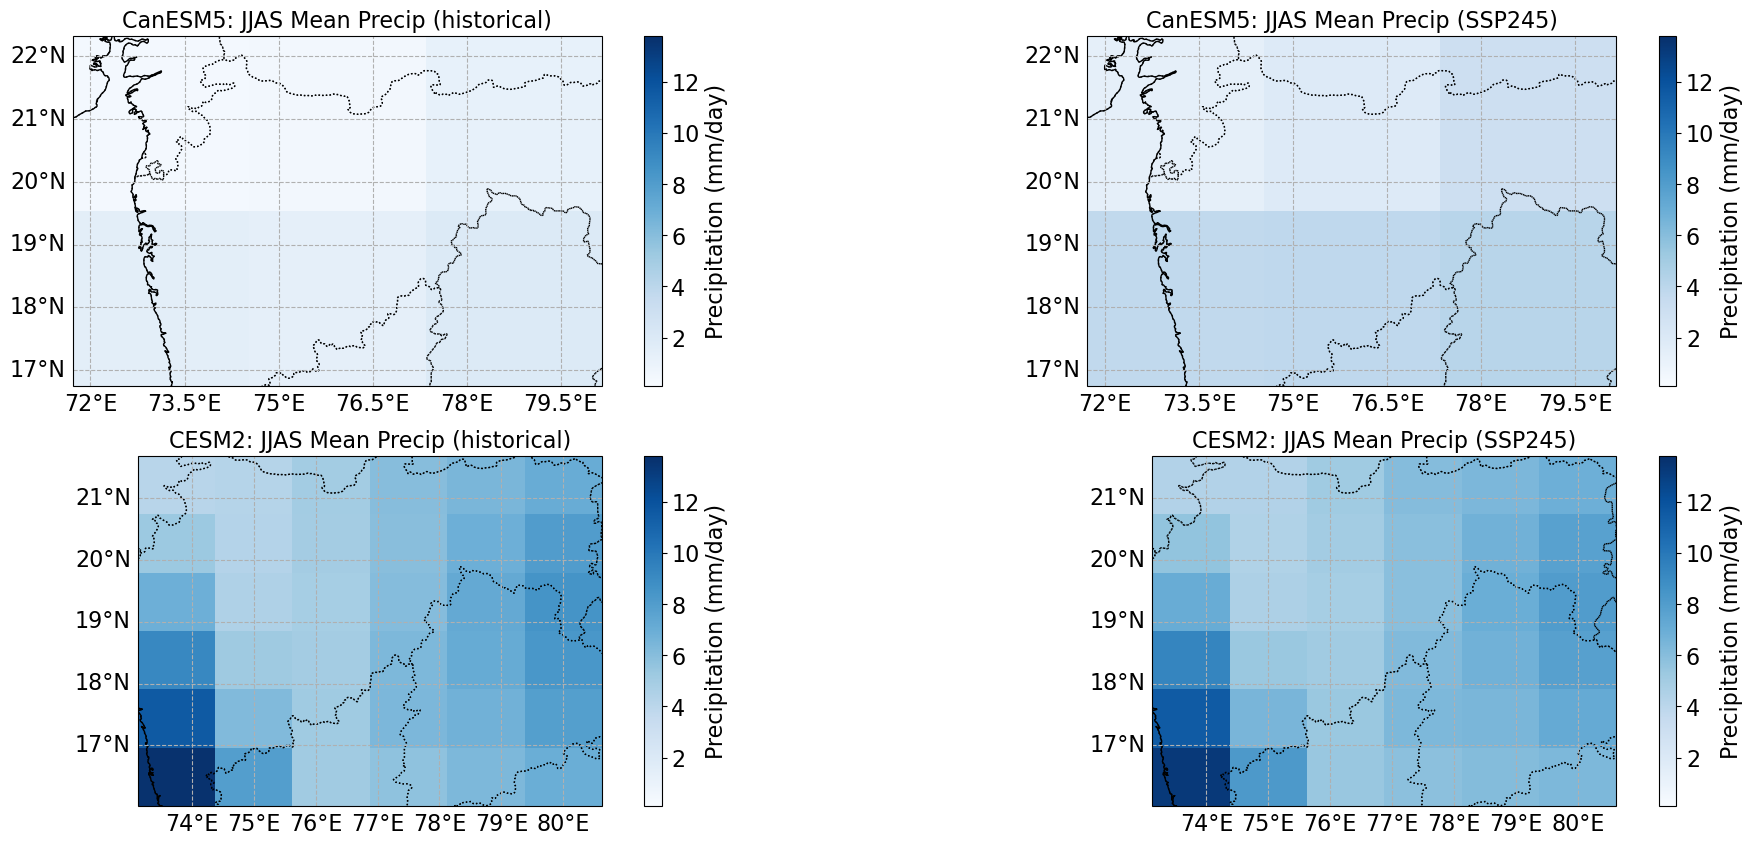

In [448]:
map = ccrs.PlateCarree()

# Make a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 10), subplot_kw={"projection": map})

# Subplot 1: CanESM5 - Historical
plot1 = axes[0, 0].pcolormesh(CAN_hist_mn_pr.lon, CAN_hist_mn_pr.lat, 
                            CAN_hist_mn_val_pr, transform=map, cmap="Blues",
                            vmin = 0.1, vmax=13.8)
                            #vmin=CAN_hist_mn_pr_np.min(), vmax=CAN_hist_mn_pr_np.max())

# Add coastlines, state borders, and gridlines
axes[0, 0].add_feature(cfeature.COASTLINE)
axes[0, 0].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[0, 0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot1, ax=axes[0, 0],
                    orientation="vertical")
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0, 0].set_title("CanESM5: JJAS Mean Precip (historical)", fontsize=16)


# Subplot 2: CanESM5 - SSP245
plot2 = axes[0, 1]. pcolormesh(CAN_ssp_mn_pr.lon, CAN_ssp_mn_pr.lat, 
                            CAN_ssp_mn_val_pr, transform=map, cmap="Blues",
                            vmin=0.1, vmax=13.8)

# Add coastlines, state borders, and gridlines
axes[0, 1].add_feature(cfeature.COASTLINE)
axes[0, 1].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[0, 1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot2, ax=axes[0, 1],
                    orientation="vertical")
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0, 1].set_title("CanESM5: JJAS Mean Precip (SSP245)", fontsize=16)

# Subplot 3: CESM2 - Historical
plot3 = axes[1, 0]. pcolormesh(CESM_hist_mn_pr.lon, CESM_hist_mn_pr.lat, 
                            CESM_hist_mn_val_pr, transform=map, cmap="Blues",
                            vmin=0.1, vmax=13.8)

# Add coastlines, state borders, and gridlines
axes[1, 0].add_feature(cfeature.COASTLINE)
axes[1, 0].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[1, 0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot3, ax=axes[1, 0],
                    orientation="vertical")
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1, 0].set_title("CESM2: JJAS Mean Precip (historical)", fontsize=16)

# Subplot 4: CESM2 - SSP245
plot4 = axes[1, 1]. pcolormesh(CESM_ssp_mn_pr.lon, CESM_ssp_mn_pr.lat, 
                            CESM_ssp_mn_val_pr, transform=map, cmap="Blues",
                            vmin=0.1, vmax=13.8)   

# Add coastlines, state borders, and gridlines
axes[1, 1].add_feature(cfeature.COASTLINE)
axes[1, 1].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[1, 1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot4, ax=axes[1, 1],
                    orientation="vertical")
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1, 1].set_title("CESM2: JJAS Mean Precip (SSP245)", fontsize=16)


### Create maps to compare mean surface air temperatures across the two models and periods

In [449]:
CAN_hist_mn_tas_np = np.nan_to_num(CAN_hist_mn_tas, nan=0.0)
CAN_ssp_mn_tas_np = np.nan_to_num(CAN_ssp_mn_tas, nan=0.0)

CESM_hist_mn_tas_np = np.nan_to_num(CESM_hist_mn_tas, nan=0.0)
CESM_ssp_mn_tas_np = np.nan_to_num(CESM_ssp_mn_tas, nan=0.0)

print(CAN_hist_mn_tas_np.min(), CAN_hist_mn_tas_np.max(), CAN_ssp_mn_tas_np.min(), CAN_ssp_mn_tas_np.max())
print(CESM_hist_mn_tas_np.min(), CESM_hist_mn_tas_np.max(), CESM_ssp_mn_tas_np.min(), CESM_ssp_mn_tas_np.max())

27.689297 33.500412 29.943993 35.354992
24.8494 31.09207 27.225159 33.532696


Text(0.5, 1.0, 'CESM2: JJAS Mean Temp (SSP245)')

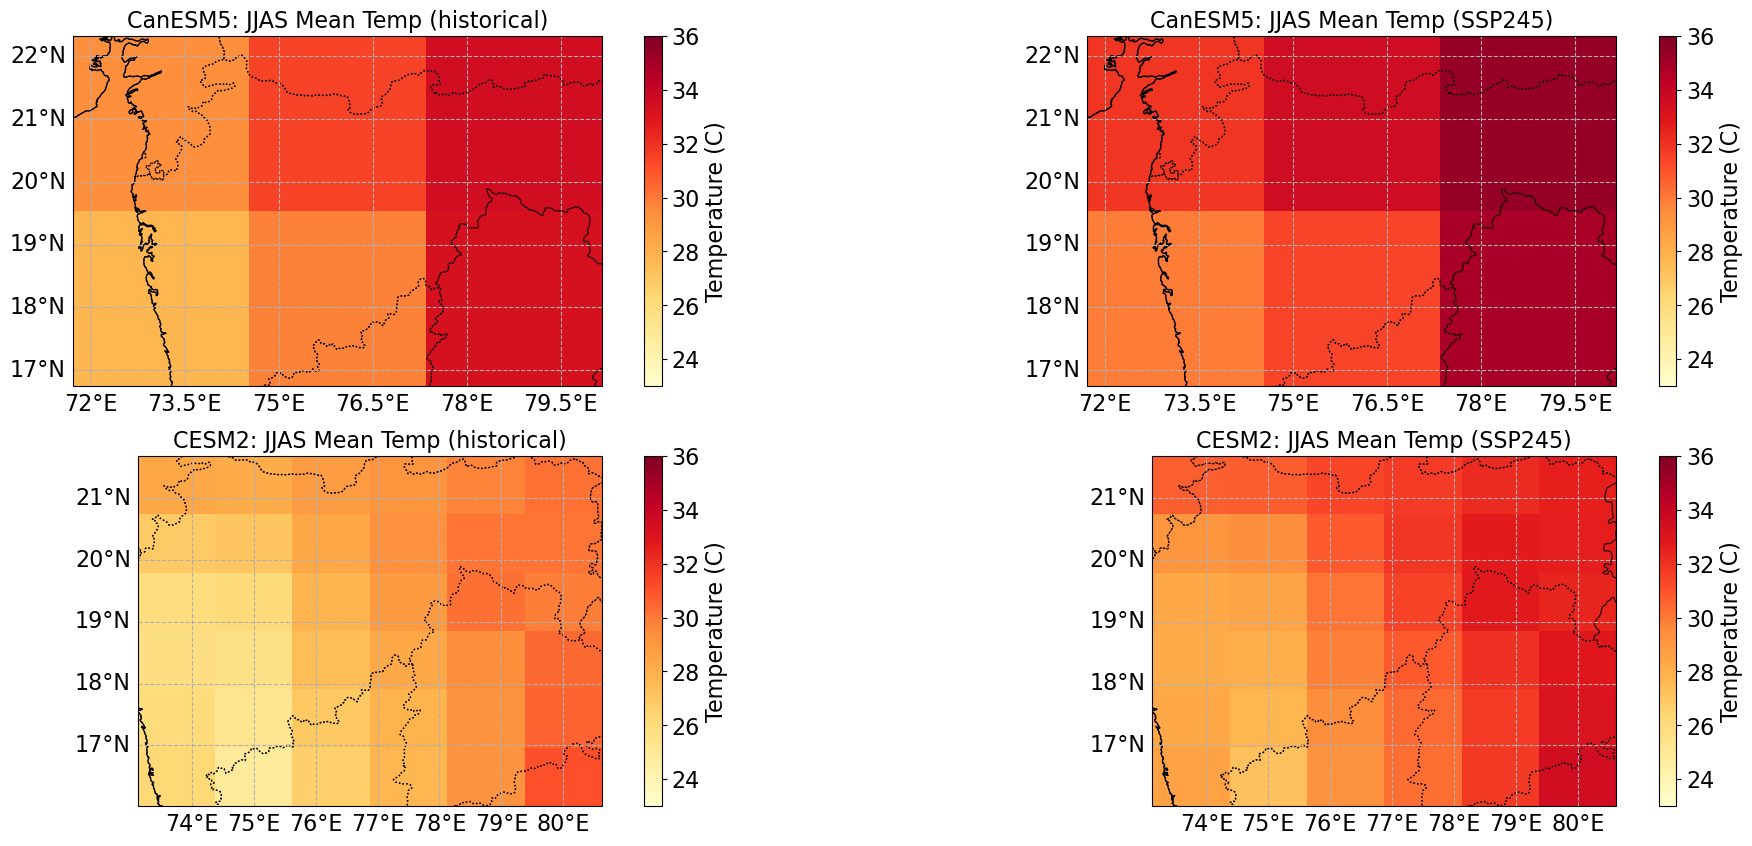

In [450]:
map = ccrs.PlateCarree()

# Make a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 10), subplot_kw={"projection": map})

# Subplot 1: CanESM5 - Historical
plot1 = axes[0, 0].pcolormesh(CAN_hist_mn_tas.lon, CAN_hist_mn_tas.lat, 
                            CAN_hist_mn_val_tas, transform=map, cmap="YlOrRd",
                            vmin=23, vmax=36)
                            #vmin=CAN_hist_mn_pr_np.min(), vmax=CAN_hist_mn_pr_np.max())

# Add coastlines, state borders, and gridlines
axes[0, 0].add_feature(cfeature.COASTLINE)
axes[0, 0].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[0, 0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot1, ax=axes[0, 0],
                    orientation="vertical")
cbar1.set_label("Temperature (C)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0, 0].set_title("CanESM5: JJAS Mean Temp (historical)", fontsize=16)


# Subplot 2: CanESM5 - SSP245
plot2 = axes[0, 1]. pcolormesh(CAN_ssp_mn_tas.lon, CAN_ssp_mn_tas.lat, 
                            CAN_ssp_mn_val_tas, transform=map, cmap="YlOrRd",
                            vmin=23, vmax=36)

# Add coastlines, state borders, and gridlines
axes[0, 1].add_feature(cfeature.COASTLINE)
axes[0, 1].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[0, 1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot2, ax=axes[0, 1],
                    orientation="vertical")
cbar1.set_label("Temperature (C)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0, 1].set_title("CanESM5: JJAS Mean Temp (SSP245)", fontsize=16)

# Subplot 3: CESM2 - Historical
plot3 = axes[1, 0]. pcolormesh(CESM_hist_mn_tas.lon, CESM_hist_mn_tas.lat, 
                            CESM_hist_mn_val_tas, transform=map, cmap="YlOrRd",
                            vmin=23, vmax=36)

# Add coastlines, state borders, and gridlines
axes[1, 0].add_feature(cfeature.COASTLINE)
axes[1, 0].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[1, 0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot3, ax=axes[1, 0],
                    orientation="vertical")
cbar1.set_label("Temperature (C)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1, 0].set_title("CESM2: JJAS Mean Temp (historical)", fontsize=16)

# Subplot 4: CESM2 - SSP245
plot4 = axes[1, 1]. pcolormesh(CESM_ssp_mn_tas.lon, CESM_ssp_mn_tas.lat, 
                            CESM_ssp_mn_val_tas, transform=map, cmap="YlOrRd",
                            vmin=23, vmax=36)   

# Add coastlines, state borders, and gridlines
axes[1, 1].add_feature(cfeature.COASTLINE)
axes[1, 1].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[1, 1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot4, ax=axes[1, 1],
                    orientation="vertical")
cbar1.set_label("Temperature (C)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1, 1].set_title("CESM2: JJAS Mean Temp (SSP245)", fontsize=16)


#### Plot Difference in Precipitation Between Historical Observations and Future Projections on the Map

In [451]:
# get max and min values excluding NaN values
CAN_JJAS_diff_np = np.nan_to_num(CAN_JJAS_diff_pr, nan=0.0)
CESM_JJAS_diff_np = np.nan_to_num(CESM_JJAS_diff_pr, nan=0.0)
print(CAN_JJAS_diff_np.min(), CAN_JJAS_diff_np.max(), CESM_JJAS_diff_np.min(), CESM_JJAS_diff_np.max())


0.96113254572277 2.427583497645823 -0.6994883423572702 0.3048163952894116


Text(0.5, 1.0, 'CESM: JJAS Mean Temp Difference (SSP245-Historical)')

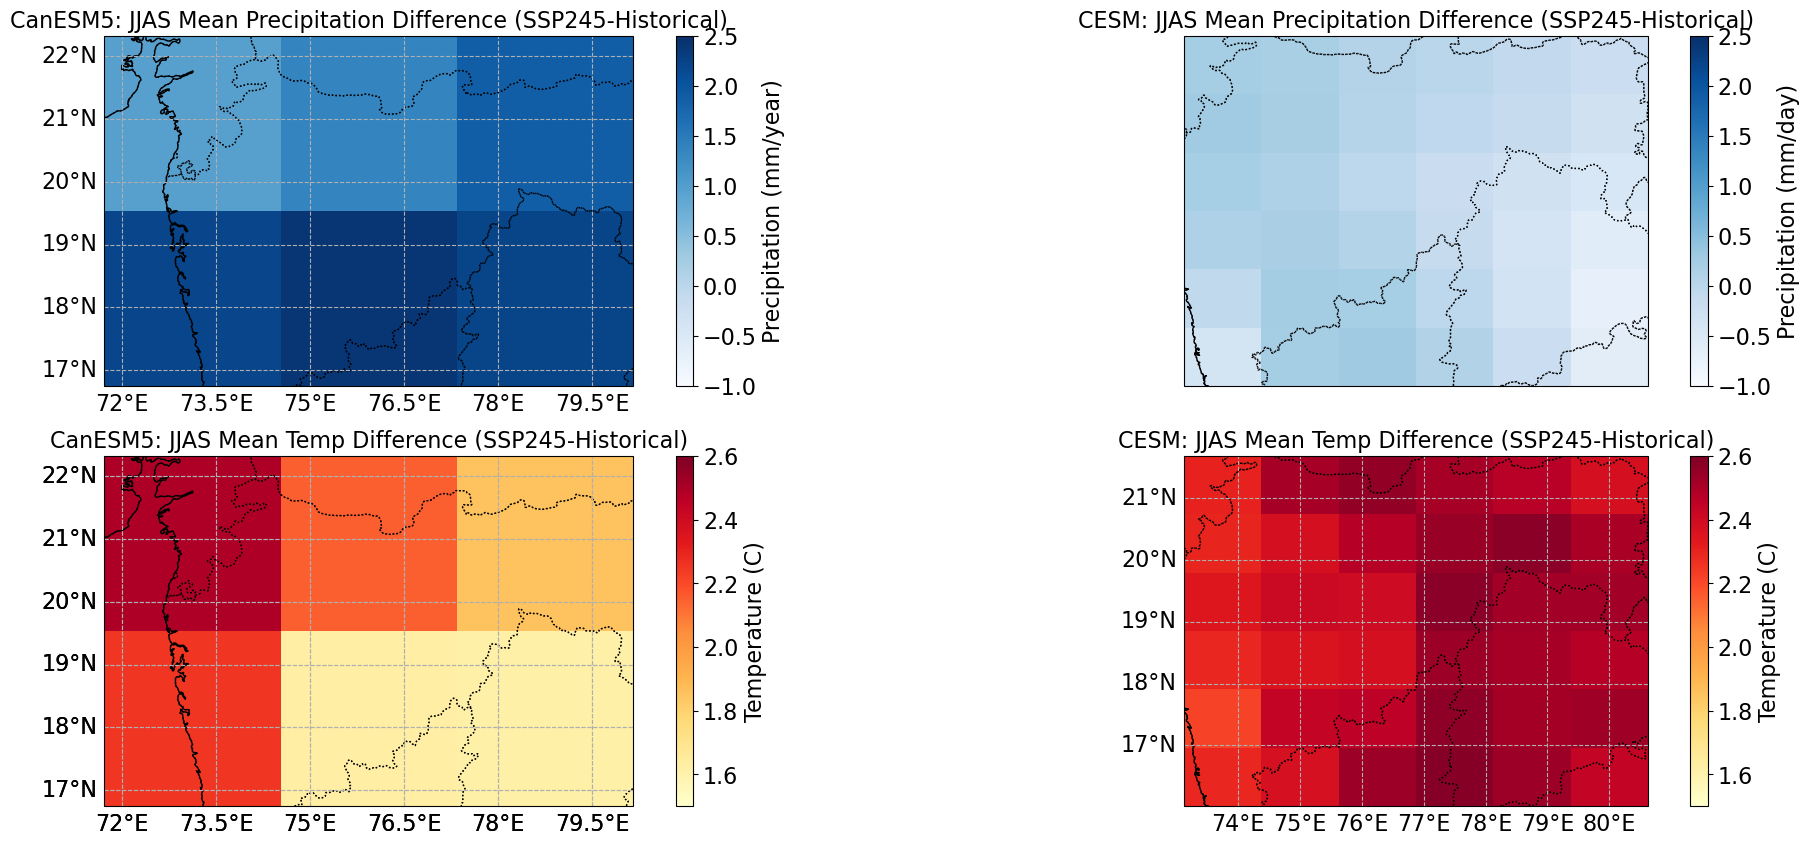

In [452]:
map = ccrs.PlateCarree()

# Make a figure with two subplots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(24, 10), subplot_kw={"projection": map})

# Subplot 1: CanESM5 - Difference
plot1 = axes[0, 0]. pcolormesh(CAN_JJAS_diff_pr.lon, CAN_JJAS_diff_pr.lat, 
                            CAN_JJAS_diff_val_pr, transform=map, cmap="Blues",
                             vmin=-1, vmax=2.5) 

# Add coastlines, state borders, and gridlines
axes[0, 0].add_feature(cfeature.COASTLINE)
axes[0, 0].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[0, 0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot1, ax=axes[0, 0],
                    orientation="vertical")
cbar1.set_label("Precipitation (mm/year)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0, 0].set_title("CanESM5: JJAS Mean Precipitation Difference (SSP245-Historical)", fontsize=16)


# Subplot 2: CanESM- Difference
plot3 = axes[1, 0]. pcolormesh(CAN_JJAS_diff_tas.lon, CAN_JJAS_diff_tas.lat, 
                            CAN_JJAS_diff_val_tas, transform=map, cmap="YlOrRd",
                            vmin=1.5, vmax=2.6)

# Add coastlines, state borders, and gridlines
axes[1, 0].add_feature(cfeature.COASTLINE)
axes[1, 0].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[1, 0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot3, ax=axes[1, 0],
                    orientation="vertical")
cbar1.set_label("Temperature (C)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1, 0].set_title("CanESM5: JJAS Mean Temp Difference (SSP245-Historical)", fontsize=16)

# Subplot 3: CESM2 - Difference
plot2 = axes[0, 1]. pcolormesh(CESM_JJAS_diff_pr.lon, CESM_JJAS_diff_pr.lat, 
                            CESM_JJAS_diff_val_pr, transform=map, cmap="Blues",
                            vmin=-1, vmax=2.5)

# Add coastlines, state borders, and gridlines
axes[0, 1].add_feature(cfeature.COASTLINE)
axes[0, 1].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[1, 0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot2, ax=axes[0, 1],
                    orientation="vertical")
cbar1.set_label("Precipitation (mm/day)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0, 1].set_title("CESM: JJAS Mean Precipitation Difference (SSP245-Historical)", fontsize=16)

# Subplot 4: CESM2 - Difference
plot4 = axes[1, 1]. pcolormesh(CESM_JJAS_diff_tas.lon, CESM_JJAS_diff_tas.lat, 
                            CESM_JJAS_diff_val_tas, transform=map, cmap="YlOrRd",
                            vmin=1.5, vmax=2.6)   

# Add coastlines, state borders, and gridlines
axes[1, 1].add_feature(cfeature.COASTLINE)
axes[1, 1].add_feature(cfeature.STATES, linestyle=":")

gl1 = axes[1, 1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {"size": 16}
gl1.ylabel_style = {"size": 16}

# Add colorbar
cbar1 =plt.colorbar(plot4, ax=axes[1, 1],
                    orientation="vertical")
cbar1.set_label("Temperature (C)", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1, 1].set_title("CESM: JJAS Mean Temp Difference (SSP245-Historical)", fontsize=16)

## Interpretation of Results

### Precipitation Changes
The CanESM5 and CESM2 models show slightly different trends in precipitation over the western region of India, particularly during the monsoon season. The CanESM5 model indicates a slight increase in precipitation, while the CESM2 model shows a slight decrease in the southern part of the region. These differences may stem from the models' structural variations and resolution, with CanESM5 having a coarser spatial resolution. As a result CanESM5 model is not able to accurately capture local-level precipitation in Maharashtra, which has diverse range of rainfall zones. Downscaled models or regional climated models can provide more accurate insights into precipitation patterns in this region.

### Temperature Changes
There is a clear trend of increasing air surface temperatures in the western region of India. When focusing specifically on the monsoon season, the average temperature is projected to rise by approximately 1.5°C to 2.6°C by the end of the century (2100), relative to the historical period (1850–2024). This warming during the monsoon season could have significant implications for agriculture, water resources, and public health in the region.


### References

- Fricko, Oliver, Petr Havlik, Joeri Rogelj, Zbigniew Klimont, Mykola Gusti, Nils Johnson, Peter Kolp, et al. “The Marker Quantification of the Shared Socioeconomic Pathway 2: A Middle-of-the-Road Scenario for the 21st Century.” Global Environmental Change 42 (2017): 251–67. https://doi.org/10.1016/j.gloenvcha.2016.06.004.
- Swart, Neil C., Jason N. S. Cole, Viatcheslav V. Kharin, Mike Lazare, John F. Scinocca, Nathan P. Gillett, James Anstey, Vivek Arora, James R. Christian, Sarah Hanna, Yanjun Jiao, Warren G. Lee, Fouad Majaess, Oleg A. Saenko, Christian Seiler, Clint Seinen, Andrew Shao, Michael Sigmond, Larry Solheim, Knut von Salzen, Duo Yang, and Barbara Winter. “The Canadian Earth System Model Version 5 (CanESM5.0.3).” Geoscientific Model Development 12 (2019): 4823–4873. https://doi.org/10.5194/gmd-12-4823-2019.
- [CMIP6 Data](https://esgf-node.llnl.gov/projects/cmip6/)


### Acknowledgements
Dr. Samantha Stevenson-Karl, Associate Professor for EDS 296-1S - Advanced Special Topics in Environmental Data Science: A Climate Modeling Perspective on Big Data Techniques\
Bren School of Environmental Science & Management\
University of California, Santa Barbara